In [1]:
from glob import glob
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hac
import seaborn as sns
from scipy.cluster.hierarchy import fcluster
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut


In [2]:
def convert_to_list(bs4row):
    list_bs4row = bs4row.findAll(["td","th"])
    return [bs4.get_text().strip() for bs4 in list_bs4row]

In [3]:
'''
(1) Get abbreviations for US states
https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations
'''
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations').text
soup = BeautifulSoup(website_url,'lxml')# get the table
my_table = soup.find("table", { "class":"wikitable sortable"})

# get the table
rows=my_table.findAll("tr")

# convert to list of list
my_data = [convert_to_list(r) for r in rows[12:70]]
df_state = pd.DataFrame(my_data,columns=['Full_name','status','ISO','ANSI1','ANSI2','USPS','USCG','GPO','AP','Other_abv'])
df_state.dropna(subset=['GPO'],inplace=True)
state_abv = dict(zip(df_state['Full_name'].tolist(),df_state['USPS'].tolist()))
abv_state = dict(zip(df_state['USPS'].tolist(),df_state['Full_name'].tolist()))

In [4]:
'''
(2) Get annunal net migration rate for US states
https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=CF
'''

fns = glob('Data/*_PEPTCOMP_with_ann.csv')
col_match_tail = " - Net Migration - Total"
col_match_head = 'Annual Estimates'

dict_year_netimg = {}
for fn in fns:
    df = pd.read_csv(fn,skiprows=1)
    df_state = df[df['Geography'].isin(state_abv.keys())]
    target_col = [col for col in df.columns if col.endswith(col_match_tail) and col.startswith(col_match_head)][0]
    d_temp = dict(zip(df_state['Geography'].tolist(),df_state[target_col].to_list()))
    dict_year_netimg[fn.split("_")[1]] = d_temp
    
df_mig = pd.DataFrame(index = state_abv.keys())
for year in dict_year_netimg:
    df_mig[year] = df_mig.index.map(dict_year_netimg[year])

df_mig.dropna(axis=0,inplace=True)

In [5]:
'''
(3) Get population in US states in 2018
source: https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population
'''
website_url = requests.get('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population').text
soup = BeautifulSoup(website_url,'lxml')# get the table
my_table = soup.find("table", { "class":"wikitable sortable"})

# get the table
rows=my_table.findAll("tr")

# convert to list of list
header = convert_to_list(rows[0])
my_data = [convert_to_list(r) for r in rows[1:]]
df_pop = pd.DataFrame(my_data,columns=header)
list_state = df_mig.index
df_pop = df_pop[df_pop['Name'].isin(list_state)]
d_state_pop2018 = dict(zip(df_pop['Name'].tolist(),
                           [int(pop.replace(',','')) for pop in df_pop['Population estimate, July 1, 2018[4]'].tolist()]))

In [6]:
'''
(3) caluculate population by states for each year
'''
d_year_pop = {2018:d_state_pop2018}

for i in range(8):
    year = 2018 - i
    net_mig = dict(zip(df_mig.index,df_mig[str(year)]))
    d_state_pop = {}
    for state in list_state:
        d_state_pop[state] = d_year_pop[year][state]+net_mig[state]
    d_year_pop[year-1] = d_state_pop

In [7]:
'''
(4) caluculate migration rate (per 1000 people) by states
'''

df_rate = pd.DataFrame(index = list_state)
for year in range(2011,2019):
    d_state_rate = {}
    for state in list_state:
        d_state_rate[state] = df_mig.loc[state,str(year)]/d_year_pop[year][state]*1000
    df_rate[year] = df_rate.index.map(d_state_rate)    
df_rate

2011       2012       2013       2014       2015  \
Alabama                1.045663   1.192060   1.159907   1.555191   0.704403   
Alaska                 0.999376  -0.617467  -3.089143 -11.249916  -7.069564   
Arizona                3.618293   6.166023   4.941527   7.506323   8.522356   
Arkansas               2.193701   0.589794   0.308014  -0.216618   0.884729   
California             2.007394   2.207610   1.857695   3.256551   2.615101   
Colorado               5.571255   6.221893   7.509651   8.612107  11.577663   
Connecticut           -1.065457  -1.026411  -0.430884  -2.596100  -2.492736   
Delaware               3.767921   5.614696   5.415791   7.207155   7.260494   
District of Columbia  11.720755  12.111628  12.570716   6.803228  11.553888   
Florida                7.609197   8.725590   8.366588  11.114086  14.930570   
Georgia                3.564565   4.333367   1.478258   4.355333   5.896311   
Hawaii                 1.938141   4.375128   4.258940   2.454082   2.211419   
Idaho                  1.153833   0.656755   3.331048   5.118086   4.983625   
Illinois              -3.193873  -3.596383  -3.199946  -5.030084  -5.405667   
Indiana               -0.280442  -0.681735   1.224992   0.390810  -0.343610   
Iowa                   0.532935   0.203589   1.517099   1.438489   0.776971   
Kansas                -1.404265  -0.046515  -2.599476  -2.733260  -1.983473   
Kentucky               1.710787   0.195468   0.730532   0.489042  -0.009139   
Louisiana              1.323804   1.190871   0.911203   0.310985   0.198471   
Maine                  0.490952   0.633627  -0.280959   1.408991  -0.140289   
Maryland               2.181843   2.982080   2.706615   2.256720   1.090308   
Massachusetts          1.610033   2.955787   4.068169   2.995016   3.115155   
Michigan              -2.805716  -1.602788  -1.107046  -0.859273  -1.470060   
Minnesota              0.825527   0.767074   1.948908   1.288950   0.570349   
Mississippi           -1.124104  -1.175812  -1.631030  -2.414569  -3.192499   
Missouri              -1.056941  -1.015170  -0.024418   0.092309   0.238726   
Montana                3.580249   3.964311   5.645000   4.869987   5.544578   
Nebraska               0.725001   1.124809   1.300219   0.647690   1.059945   
Nevada                 0.508613   6.944142   6.265974   9.992356  11.696251   
New Hampshire         -1.158983   0.632837  -0.416396   2.285230   0.783685   
New Jersey            -1.617613  -0.303147   0.150751  -0.432800  -0.919376   
New Mexico             1.730157  -2.550570  -4.278417  -5.545732  -4.673239   
New York              -1.333394  -0.988427  -0.139914  -1.822110  -1.234864   
North Carolina         4.771811   5.557430   5.371529   5.368591   5.947483   
North Dakota           7.696824  14.742661  23.368684  13.466635  15.634682   
Ohio                  -2.230315  -1.895410  -0.631689  -0.060463  -0.906033   
Oklahoma               3.024357   3.677034   4.794165   2.543652   3.922769   
Oregon                 4.241160   4.163059   3.769739   6.755880   9.919443   
Pennsylvania           0.582746   0.491143  -0.446521  -0.186315  -0.441795   
Rhode Island          -2.882643  -1.686649  -0.220811   0.852830   0.032112   
South Carolina         4.362486   6.527062   6.704782   8.473075   9.982472   
South Dakota           2.758345   5.743915   6.487894   2.253802  -0.094133   
Tennessee              3.451376   5.298041   2.982415   4.850412   4.670014   
Texas                  6.276713   7.023180   5.962135   8.086533   9.272810   
Utah                   1.250326   1.449135   3.048465   1.301592   4.868089   
Vermont               -0.486564  -1.811292  -0.302859  -1.328249  -2.090413   
Virginia               3.410854   4.733272   3.822707   1.585756   1.749368   
Washington             6.092311   4.626833   4.852421   6.599231   8.813711   
West Virginia          1.151016   1.221071  -0.513486  -0.890637  -1.873283   
Wisconsin             -0.521032  -0.678173  -0.392636  -0.581389  -1.202085  

In [8]:
import folium

state_geo = 'Data/us-states.json'
m = folium.Map(location=[37, -102], zoom_start=5)

df_map = pd.DataFrame({'code':[state_abv[s] for s in df_rate.index],
                       'rate_2018':df_rate[2018]})
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_map,
    columns=['code','rate_2018'],
    key_on='feature.id',
    fill_color='RdBu',
    fill_opacity=0.5,
    line_opacity=0.2,
    threshold_scale=[-40,-30,-20,-10,0,10,20,30,40]
).add_to(m)

folium.LayerControl().add_to(m)
m

In [9]:
df_rate_T =df_rate.transpose()

In [10]:
def plot_state_mig_rates(df_rate_T,list_state,fig_name):
    
    plt.figure(figsize=(12,len(list_state)//2))

    for idx,state in enumerate(list_state):
        plt.subplot(len(list_state)//4+1, 4, idx+1)
        ax=sns.lineplot(data=df_rate_T[state])
        ax.set_title(state)
        ax.set_ylim([-30,30])

    plt.tight_layout()
    plt.savefig(fig_name,dpi=300)

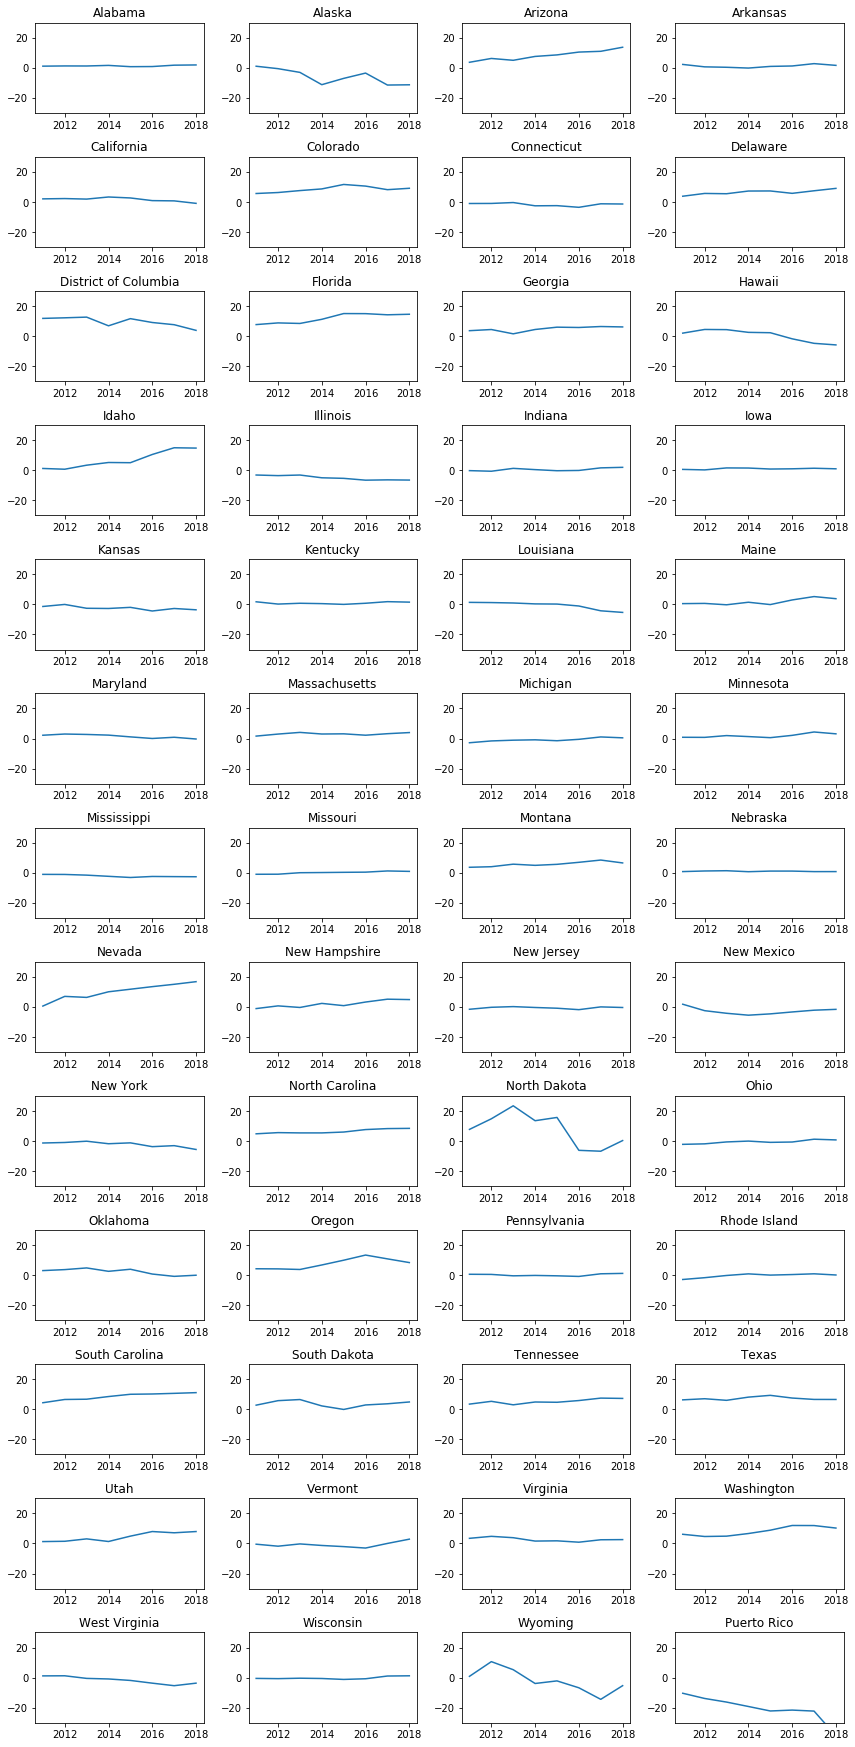

In [11]:
df_rate_T =df_rate.transpose()
plot_state_mig_rates(df_rate_T,list_state,'state_migration_rate_ALL.png')

In [12]:
def time_series_clustering_and_plot(df_rate,list_state,fig_name):

    '''
    the code is adapted from:
    https://stackoverflow.com/questions/34940808/hierarchical-clustering-of-time-series-in-python-scipy-numpy-pandas
    '''
    # Do the clustering
    df_temp = df_rate[df_rate.index.isin(list_state)]
    Z = hac.linkage(df_temp, method='single', metric='correlation')

    # Plot dendogram
    plt.figure(figsize=(12,len(list_state)//3))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('States')
    plt.ylabel('distance')
    hac.dendrogram(
        Z,
        orientation='right',
        leaf_font_size=12,  # font size for the x axis labels
        labels=df_rate.index
    )
    plt.tight_layout()
    plt.savefig(fig_name,dpi=300)
    return Z

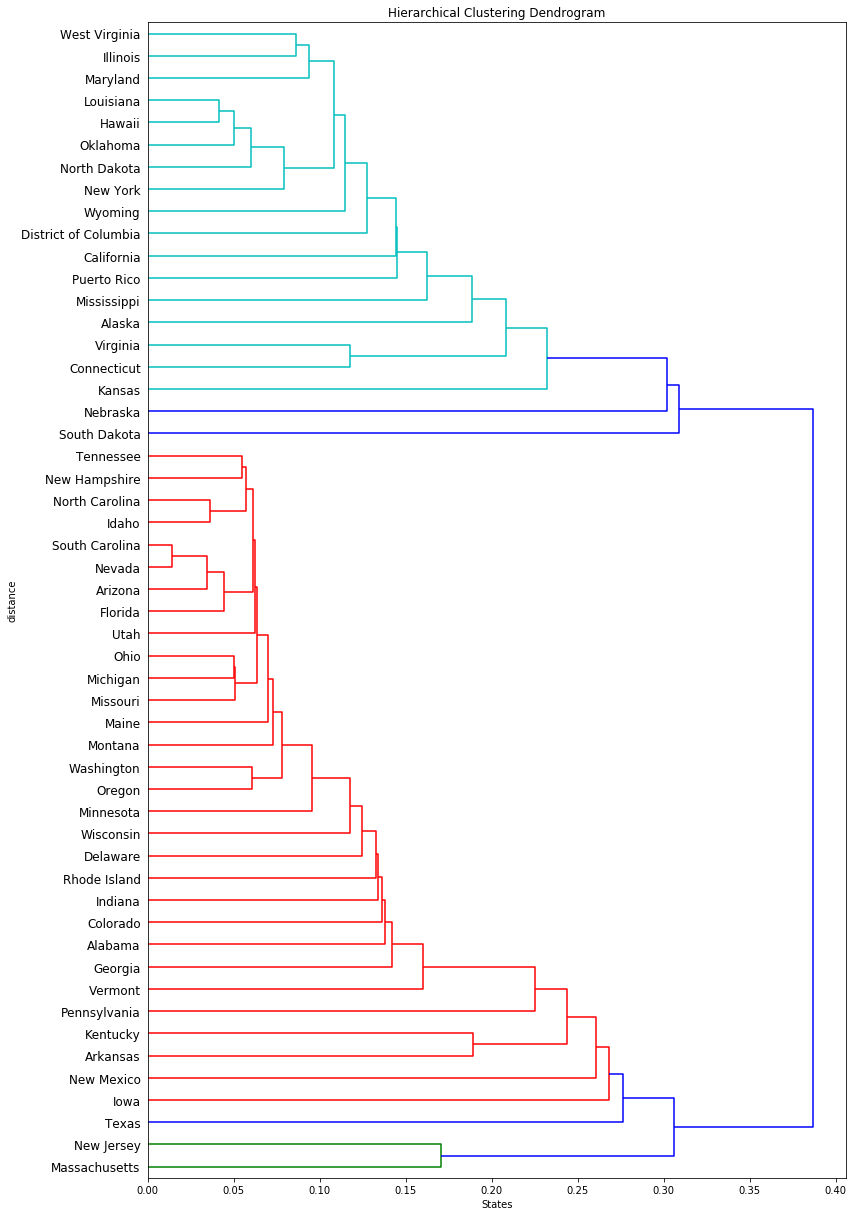

In [13]:
Z = time_series_clustering_and_plot(df_rate,list_state,"states_mig_rate_Dendrogram_ALL.png")

In [14]:
def get_dict_sub_cluster(Z,k):

    list_clusters = list(fcluster(Z,k,criterion='maxclust'))
    clusters = list(set(list_clusters))

    d_cluster_states = {}
    for cluster in clusters:
        idxes = [i for i,c in enumerate(list_clusters) if c==cluster]
        d_cluster_states[cluster] = df_rate.index[idxes].tolist()
    return d_cluster_states

In [15]:
d_cluster_states = get_dict_sub_cluster(Z,10)
d_cluster_states

{1: ['Massachusetts', 'New Jersey'],
 2: ['Arkansas', 'Kentucky'],
 3: ['Alabama',
  'Arizona',
  'Colorado',
  'Delaware',
  'Florida',
  'Georgia',
  'Idaho',
  'Indiana',
  'Maine',
  'Michigan',
  'Minnesota',
  'Missouri',
  'Montana',
  'Nevada',
  'New Hampshire',
  'North Carolina',
  'Ohio',
  'Oregon',
  'Pennsylvania',
  'Rhode Island',
  'South Carolina',
  'Tennessee',
  'Utah',
  'Vermont',
  'Washington',
  'Wisconsin'],
 4: ['New Mexico'],
 5: ['Iowa'],
 6: ['Texas'],
 7: ['Alaska',
  'California',
  'Connecticut',
  'District of Columbia',
  'Hawaii',
  'Illinois',
  'Louisiana',
  'Maryland',
  'Mississippi',
  'New York',
  'North Dakota',
  'Oklahoma',
  'Virginia',
  'West Virginia',
  'Wyoming',
  'Puerto Rico'],
 8: ['Kansas'],
 9: ['Nebraska'],
 10: ['South Dakota']}

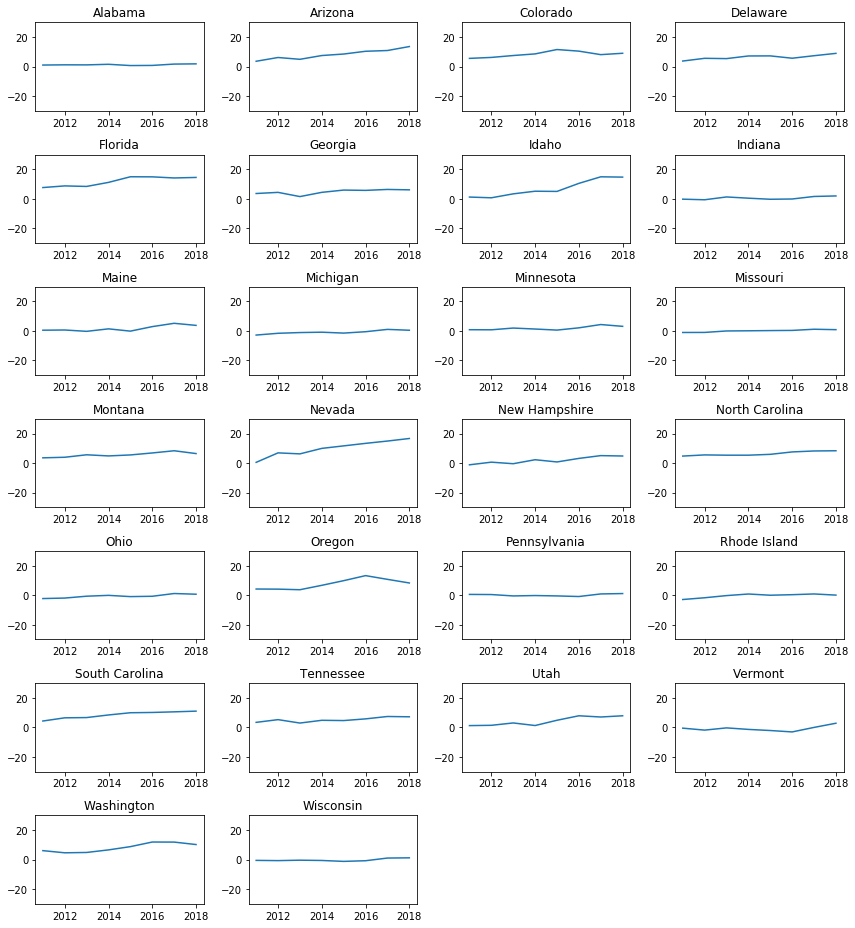

In [16]:
plot_state_mig_rates(df_rate_T,d_cluster_states[3],'state_migration_rate_subcluster1.png')

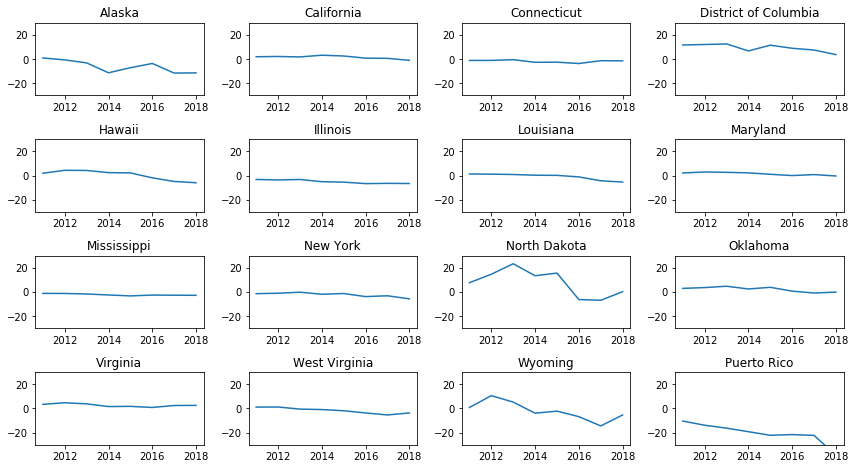

In [17]:
plot_state_mig_rates(df_rate_T,d_cluster_states[7],'state_migration_rate_subcluster2.png')

In [18]:
p_decrease = d_cluster_states[7]
p_increase = d_cluster_states[3]

In [19]:
df_linkedin = pd.read_csv("Data/temp_datalab_records_linkedin_company.csv")
df_linkedin_clean = df_linkedin.dropna(subset=['industry'])
df_linkedin_clean.loc[:,'industry']=df_linkedin_clean['industry'].apply(lambda s: s.replace('&amp;','&'))
d_company_industry = dict(df_linkedin_clean.groupby('company_name')['industry'].apply(list))

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
df_job = pd.read_csv("Data/job_listings_USA.csv", encoding = "ISO-8859-1",header=None)
df_job.columns = ['Title','Brand','Category','City','State','Date']
df_job['Date'] = pd.to_datetime(df_job['Date'], errors='coerce')
df_job['Industry'] = df_job['Brand'].apply(lambda s: d_company_industry[s][0] if s in d_company_industry else np.nan)
df_job = df_job.dropna(subset=['Industry'])

In [21]:
def get_state(row,abv_state):
    if row['State'] in abv_state:
        return abv_state[row['State']]
    elif row['City'] in abv_state:
        return abv_state[row['City']]
    else:
        return np.nan
df_job.loc[:,'State_Full'] = df_job.apply(lambda row: get_state(row,abv_state), axis=1)
df_job = df_job.dropna(subset=['State_Full'])

In [22]:
df_job

Title  \
0          Automotive Technician Coggin Honda St. Augustine   
1         Part Time Receptionist / Nights and Weekends /...   
2         Service Technician & Used Technician McDavid P...   
3                 Part-time Receptionist / Plaza Land Rover   
4         Automotive Service Technician McDavid Honda Ir...   
5                           Sales Consultant / Nalley Honda   
6         Quick Lube Technician McDavid Honda Frisco Int...   
7               Sales Consultant at Crown Ford Fayetteville   
8                   Body Shop Estimator / Toyota of Roswell   
9                   Sales Manager / Nalley Infiniti Atlanta   
10             Service Porter / Service Valet / Nalley Ford   
11        Sales Consultant / Jaguar Porsche Land Rover &...   
12                   Sales Advisor at Crown CDJR Greensboro   
13                             Sr. Development Engineer -L3   
14                                MALDI Biotyper Specialist   
15                                            HR Generalist   
16                                    Internal Audit Intern   
17        Sales Specialist - Bruker BioSpin Services & L...   
18                Field Microbiology Application Specialist   
19        Bruker Applied Spectroscopy Sales Representati...   
20                     Market Segment Manager BNA Worldwide   
21                 Part-Time Temporary Maintenance Mechanic   
22                               Sr. Staff Optical Engineer   
23                                  Staff Software Engineer   
24                                 Internal Controls Intern   
25                                             Buyer - Temp   
26                              Quality Control Intern - NI   
27        FM -Sr. Staff Manufacturing Engineer - Microscopy   
28                             Mechanical Engineer - Intern   
29                                         Material Handler   
...                                                     ...   
12421351                   Hardware Systems Design Engineer   
12421377                         ASIC Verification Engineer   
12421429                             Communications Manager   
12421553                                  People Consultant   
12421598                            Associate Channels Lead   
12421603                             Data Center Technician   
12421605                               Interaction Designer   
12421608      Systems Planning and Delivery Program Manager   
12421680                    Bay Area Events Program Manager   
12421682                    Data Center Electrical Engineer   
12421718                            Associate Channels Lead   
12421725                               Interaction Designer   
12421728  Data Center Construction Program Manager - Cou...   
12421788                                      Test Engineer   
12421836                  Silicon Reliability Test Engineer   
12422547                                      Data Engineer   
12425437          Senior Manufacturing Engineer - Machining   
12425482                        Field Sales Account Manager   
12425486    Senior Service Support and Development Engineer   
12425498                   Informatics Solutions Specialist   
12425511                                Material Handler II   
12425608                        Field Sales Account Manager   
12427236                  Project Manager - Project/Program   
12427241                                 Operations Manager   
12427341                                   Project Director   
12428515                               Analyst - Operations   
12428556                                   Project Director   
12428589                                 Operations Manager   
12428612                               Analyst - Operations   
12428638                  Project Manager - Project/Program   

                            Brand                      Category  \
0         Asbury Automotive Group                           NaN   
1         Asb

In [23]:
df_job_2018 = df_job[df_job['Date'].dt.year==2018]
df_job_2018['Industry'].value_counts()

Retail                                 482039
Internet                               221985
Business Supplies and Equipment        218355
Banking                                 46553
Hospital & Health Care                  41459
Information Technology and Services     30799
Automotive                              23012
Investment Banking                      22530
Apparel & Fashion                       21489
Restaurants                             20898
Government Administration               18847
Renewables & Environment                18232
Electrical/Electronic Manufacturing     15560
Construction                            14525
Logistics and Supply Chain              13932
Broadcast Media                         12443
Computer Software                       12109
Pharmaceuticals                          9208
Machinery                                6772
Research                                 6470
Packaging and Containers                 5908
Biotechnology                     

In [24]:
list_industry = df_job_2018['Industry'].value_counts().index[:20]
df_state_ind_2018 = pd.DataFrame(index=list_state)


for ind in list_industry:
    df_ind = df_job_2018[df_job_2018['Industry']==ind]
    d_state_ind_2018 = dict(df_ind.groupby('State_Full')['Title'].count())
    df_state_ind_2018[ind] = df_state_ind_2018.index.map(d_state_ind_2018)

df_state_ind_2018=df_state_ind_2018.fillna(0)

# normalize by total
df_state_ind_2018_norm = df_state_ind_2018.div(df_state_ind_2018.sum(axis=1), axis=0)
df_state_ind_2018_norm.dropna(inplace=True)

In [25]:
def get_status(p,p_decrease,p_increase):
    if p in p_decrease:
        return 0
    elif p in p_increase:
        return 1
    else:
        return np.nan
    
df_state_ind_2018_norm['p_status'] = df_state_ind_2018_norm.index
df_state_ind_2018_norm['p_status'] = df_state_ind_2018_norm['p_status'].apply(lambda p: get_status(p,p_decrease,p_increase))
df_state_ind_2018_norm.dropna(subset=['p_status'],inplace=True)

In [26]:
df_corr = pd.DataFrame(df_state_ind_2018_norm.corr()['p_status'])
df_corr.dropna(inplace=True)
df_corr = df_corr.head(len(df_corr)-1).sort_values(['p_status'],ascending =False)
df_corr.to_csv('corr_state_job.csv')
df_corr

p_status
Logistics and Supply Chain           0.260067
Construction                         0.190806
Automotive                           0.188339
Hospital & Health Care               0.173034
Pharmaceuticals                      0.144133
Electrical/Electronic Manufacturing  0.130980
Apparel & Fashion                    0.072036
Information Technology and Services  0.054305
Banking                              0.028085
Renewables & Environment             0.020396
Retail                               0.012969
Internet                             0.003406
Business Supplies and Equipment     -0.097534
Computer Software                   -0.105274
Investment Banking                  -0.107124
Machinery                           -0.111301
Research                            -0.161649
Restaurants                         -0.180800
Broadcast Media                     -0.230166
Government Administration           -0.280477

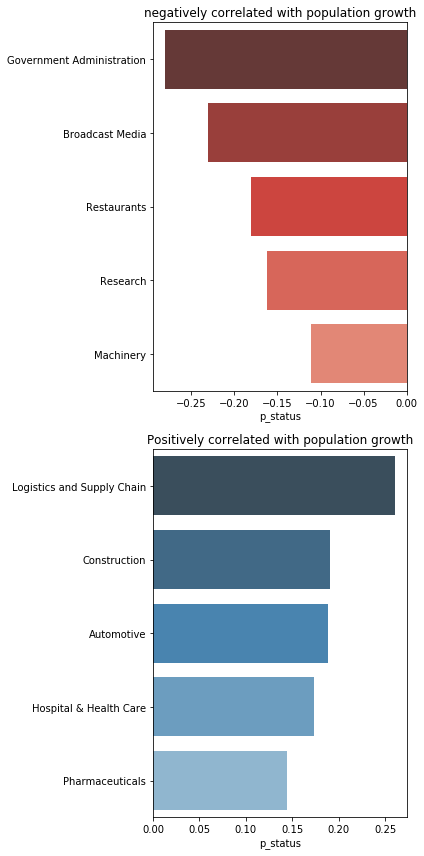

In [27]:
plt.figure(figsize=(6,12))

plt.subplot(2,1,1)
ax = sns.barplot(x='p_status',y=df_corr.tail(5).index, data = df_corr.tail(5),palette="Reds_d",
                 order=df_corr.tail(5).index[::-1])
ax.set_title('negatively correlated with population growth')

plt.subplot(2,1,2)
ax = sns.barplot(x='p_status',y=df_corr.head(5).index, data = df_corr.head(5),palette="Blues_d")
ax.set_title('Positively correlated with population growth')

plt.tight_layout()

In [28]:
list_industry = set(df_job_2018['Industry'].tolist())
df_state_ind = pd.DataFrame(index=list_state)

df_job_2018 = df_job_2018[df_job_2018['Date'].dt.year==2018]
d_state_ind = df_job_2018.groupby('State_Full')['Industry']

for ind in list_industry:
    df_ind = df_job_2018[df_job_2018['Industry']==ind]
    d_state_ind = dict(df_ind.groupby('State_Full')['Title'].count())
    df_state_ind[ind] = df_state_ind.index.map(d_state_ind)
df_state_ind=df_state_ind.fillna(0)

df_state_ind_norm = df_state_ind.div(df_state_ind.sum(axis=1), axis=0)
df_state_ind_norm.dropna(inplace=True)

In [29]:
from sklearn.cluster import KMeans

kclusters = 3
kmeans = KMeans(n_clusters=kclusters).fit(df_state_ind_norm[list_industry].values)

df_state_cluster_by_ind = pd.DataFrame({'code':[state_abv[s] for s in list_state],
                                        'state':list_state,
                                        'clusters':list(kmeans.labels_)})
df_state_cluster_by_ind

code                 state  clusters
0    AL               Alabama         1
1    AK                Alaska         2
2    AZ               Arizona         1
3    AR              Arkansas         1
4    CA            California         1
5    CO              Colorado         1
6    CT           Connecticut         0
7    DE              Delaware         0
8    DC  District of Columbia         0
9    FL               Florida         2
10   GA               Georgia         1
11   HI                Hawaii         0
12   ID                 Idaho         2
13   IL              Illinois         0
14   IN               Indiana         2
15   IA                  Iowa         1
16   KS                Kansas         1
17   KY              Kentucky         1
18   LA             Louisiana         2
19   ME                 Maine         1
20   MD              Maryland         2
21   MA         Massachusetts         0
22   MI              Michigan         2
23   MN             Minnesota         2
24   MS           Mississippi         1
25   MO              Missouri         2
26   MT               Montana         2
27   NE              Nebraska         2
28   NV                Nevada         1
29   NH         New Hampshire         0
30   NJ            New Jersey         0
31   NM            New Mexico         1
32   NY              New York         0
33   NC        North Carolina         2
34   ND          North Dakota         1
35   OH                  Ohio         1
36   OK              Oklahoma         1
37   OR                Oregon         2
38   PA          Pennsylvania         1
39   RI          Rhode Island         0
40   SC        South Carolina         1
41   SD          South Dakota         0
42   TN             Tennessee         1
43   TX                 Texas         2
44   UT                  Utah         0
45   VT               Vermont         0
46   VA              Virginia         0
47   WA            Washington         0
48   WV         West Virginia         1
49   WI             Wisconsin         2
50   WY               Wyoming         1
51   PR           Puerto Rico         1

In [30]:
d_state_clster = dict(zip(df_state_cluster_by_ind['state'].tolist(),df_state_cluster_by_ind['clusters'].tolist()))
df_job_2018.loc[:,'cluster'] = df_job_2018['State_Full'].apply(lambda s: d_state_clster[s] if s in d_state_clster else np.nan)
df_job_2018

Title  \
0          Automotive Technician Coggin Honda St. Augustine   
1         Part Time Receptionist / Nights and Weekends /...   
2         Service Technician & Used Technician McDavid P...   
3                 Part-time Receptionist / Plaza Land Rover   
4         Automotive Service Technician McDavid Honda Ir...   
5                           Sales Consultant / Nalley Honda   
6         Quick Lube Technician McDavid Honda Frisco Int...   
7               Sales Consultant at Crown Ford Fayetteville   
8                   Body Shop Estimator / Toyota of Roswell   
9                   Sales Manager / Nalley Infiniti Atlanta   
10             Service Porter / Service Valet / Nalley Ford   
11        Sales Consultant / Jaguar Porsche Land Rover &...   
12                   Sales Advisor at Crown CDJR Greensboro   
13                             Sr. Development Engineer -L3   
14                                MALDI Biotyper Specialist   
15                                            HR Generalist   
16                                    Internal Audit Intern   
17        Sales Specialist - Bruker BioSpin Services & L...   
18                Field Microbiology Application Specialist   
19        Bruker Applied Spectroscopy Sales Representati...   
20                     Market Segment Manager BNA Worldwide   
21                 Part-Time Temporary Maintenance Mechanic   
23                                  Staff Software Engineer   
24                                 Internal Controls Intern   
25                                             Buyer - Temp   
26                              Quality Control Intern - NI   
27        FM -Sr. Staff Manufacturing Engineer - Microscopy   
28                             Mechanical Engineer - Intern   
29                                         Material Handler   
30                 BNS- NI Product Line Manager (PLM) of MP   
...                                                     ...   
12421351                   Hardware Systems Design Engineer   
12421377                         ASIC Verification Engineer   
12421429                             Communications Manager   
12421553                                  People Consultant   
12421598                            Associate Channels Lead   
12421603                             Data Center Technician   
12421605                               Interaction Designer   
12421608      Systems Planning and Delivery Program Manager   
12421680                    Bay Area Events Program Manager   
12421682                    Data Center Electrical Engineer   
12421718                            Associate Channels Lead   
12421725                               Interaction Designer   
12421728  Data Center Construction Program Manager - Cou...   
12421788                                      Test Engineer   
12421836                  Silicon Reliability Test Engineer   
12422547                                      Data Engineer   
12425437          Senior Manufacturing Engineer - Machining   
12425482                        Field Sales Account Manager   
12425486    Senior Service Support and Development Engineer   
12425498                   Informatics Solutions Specialist   
12425511                                Material Handler II   
12425608                        Field Sales Account Manager   
12427236                  Project Manager - Project/Program   
12427241                                 Operations Manager   
12427341                                   Project Director   
12428515                               Analyst - Operations   
12428556                                   Project Director   
12428589                                 Operations Manager   
12428612                               Analyst - Operations   
12428638                  Project Manager - Project/Program   

                            Brand                      Category  \
0         Asbury Automotive Group                           NaN   
1         Asb

In [31]:
df_cluster_ind_2018 = pd.DataFrame(index=list(range(3)))

for ind in list_industry:
    df_ind = df_job_2018[df_job_2018['Industry']==ind]
    d_c_ind = dict(df_ind.groupby('cluster')['Title'].count())
    df_cluster_ind_2018[ind] = df_cluster_ind_2018.index.map(d_c_ind)

df_cluster_ind_2018=df_cluster_ind_2018.fillna(0)    
df_cluster_ind_2018_norm = df_cluster_ind_2018.div(df_cluster_ind_2018.sum(axis=1), axis=0)
df_cluster_ind_2018_norm.transpose().to_csv('industry_dis_by_cluster.csv')

In [32]:
neg_corr = df_corr.tail(5).index
pos_corr = df_corr.head(5).index

In [33]:
def plot_job_dist_by_corr(df_cluster_ind_2018_norm,list_corr,file_name):
    plt.figure(figsize=(12,len(list_corr)//5*3))
    for i,industry in enumerate(list_corr):
        plt.subplot(len(list_corr)//5, 5, i+1)
        ax=sns.barplot(data=[[df_cluster_ind_2018_norm.loc[0,industry]],
                             [df_cluster_ind_2018_norm.loc[1,industry]],
                             [df_cluster_ind_2018_norm.loc[2,industry]],
                            ])
        ax.set_title(industry)

    plt.tight_layout()
    plt.savefig(file_name,dpi=300)

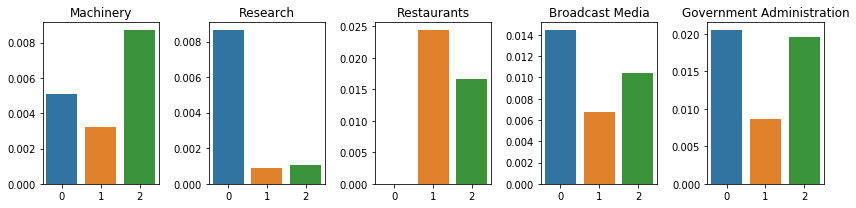

In [34]:
plot_job_dist_by_corr(df_cluster_ind_2018_norm,neg_corr,'job_distr_of_negative_corr.png')

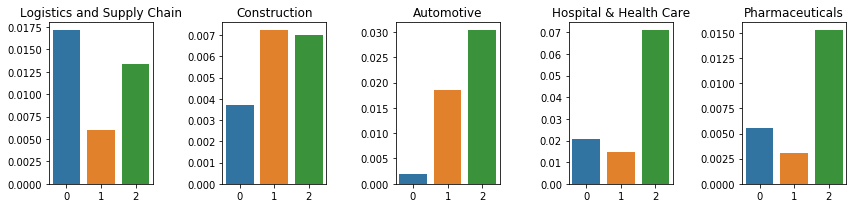

In [35]:
plot_job_dist_by_corr(df_cluster_ind_2018_norm,pos_corr,'job_distr_of_positive_corr.png')

In [36]:
dict_cluster_statelist = dict(df_state_cluster_by_ind.groupby('clusters')['state'].apply(list))
dict_cluster_statelist

{0: ['Connecticut',
  'Delaware',
  'District of Columbia',
  'Hawaii',
  'Illinois',
  'Massachusetts',
  'New Hampshire',
  'New Jersey',
  'New York',
  'Rhode Island',
  'South Dakota',
  'Utah',
  'Vermont',
  'Virginia',
  'Washington'],
 1: ['Alabama',
  'Arizona',
  'Arkansas',
  'California',
  'Colorado',
  'Georgia',
  'Iowa',
  'Kansas',
  'Kentucky',
  'Maine',
  'Mississippi',
  'Nevada',
  'New Mexico',
  'North Dakota',
  'Ohio',
  'Oklahoma',
  'Pennsylvania',
  'South Carolina',
  'Tennessee',
  'West Virginia',
  'Wyoming',
  'Puerto Rico'],
 2: ['Alaska',
  'Florida',
  'Idaho',
  'Indiana',
  'Louisiana',
  'Maryland',
  'Michigan',
  'Minnesota',
  'Missouri',
  'Montana',
  'Nebraska',
  'North Carolina',
  'Oregon',
  'Texas',
  'Wisconsin']}